# 0. Imports

In [3]:
import sys
import os
import pandas as pd

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))

import data_acquisition
import Dataframe
import feature_engineering
import Dataframe_milestone_2


# 1. Collecting Data

In [4]:
data_acquisition.collect_data()

The folder '../data/raw/2016_2017' already exists.
The folder '../data/raw/2017_2018' already exists.
The folder '../data/raw/2018_2019' already exists.
The folder '../data/raw/2019_2020' already exists.
The folder '../data/raw/2020_2021' already exists.


# 2. Cleaning Data

In [5]:
## environ 2 minutes

base_path = '../data/raw/'
df = Dataframe.load_all_seasons(base_path)
transformed_df = Dataframe.transformEventData(df)

Seasons: 100%|██████████| 5/5 [02:51<00:00, 34.38s/it]              


## Ingénierie des caractéristiques 1

In [6]:
# Charger les données
data = pd.read_csv('../data/derivatives/dataframe.csv')
# Créer les nouvelles caractéristiques
feature_engineering.create_features1(data, '^201[6-9]02\d{4}$', 'features_train1.csv')

## Ingénierie des caractéristiques 2

In [45]:
transformed_df = Dataframe_milestone_2.transformEventData(df)

In [8]:
Dataframe = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')
data = feature_engineering.create_features2(Dataframe, pattern=None)
data.to_csv('../data/derivatives/dataframe_milestone_2.csv', index=False)

D:\UdeM\Automne2023\IFT6758-DataScience\Projet\ift6758-A08\scripts\feature_engineering.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  angle = np.arctan((y_goal - y)/(x_goal - np.abs(x)))
D:\UdeM\Automne2023\IFT6758-DataScience\Projet\ift6758-A08\scripts\feature_engineering.py:57: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arctan((y_goal - y)/(x_goal - np.abs(x)))


In [ ]:
# Question 5 :
feature_engineering.comet_log_dataframe_profile()

In [9]:
# Séparation en un jeu de d'entrainement/test

# Filtre pour les saisons 2016/2017 et 2018/2019
train_data = data[(data['gameId'].astype(str).str.startswith('2016')) |
                  (data['gameId'].astype(str).str.startswith('2018'))]

# Filtre pour la saison 2019/2020
test_data = data[data['gameId'].astype(str).str.startswith('2019')]

train_data.to_csv('../data/derivatives/train_data.csv', index=False)
test_data.to_csv('../data/derivatives/test_data.csv', index=False)

# Modele de base

In [11]:
import sys
import os
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, RocCurveDisplay, roc_auc_score , roc_curve, auc
from sklearn.calibration import CalibrationDisplay, calibration_curve

In [12]:
data = pd.read_csv('../data/derivatives/features_train1.csv')

In [13]:
X = data['distance_goal']
y = data['is_goal']
X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
        )

In [14]:
# LogisticRegression prend des shape de (n,)
X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
reshaped_X_val = X_val.values.reshape(-1,1)
reshaped_y_val = y_val.values.reshape(-1,1)

### Régression logistique entrainée sur la caractéristique 'Distance' uniquement

In [15]:
clf = LogisticRegression().fit(X_train, y_train)

C:\Users\mathi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Précsion du model

In [16]:
y_pred = clf.predict(reshaped_X_val)

# Calculer la précision du modèle
accuracy = accuracy_score(reshaped_y_val, y_pred)
print(accuracy)

0.9062459123610203


In [17]:
y_score = clf.predict_proba(reshaped_X_val)
print(y_score)
# la première colonne est la probabilité que le model ne prédit pas un but pour la ligne d'entrée correspondante
# la deuxieme colonne est la probabilté que le model ne prédit un but pour la ligne d'entrée correspondante

[[0.96612945 0.03387055]
 [0.81085416 0.18914584]
 [0.81446129 0.18553871]
 ...
 [0.8002089  0.1997911 ]
 [0.89720899 0.10279101]
 [0.91438653 0.08561347]]


AUC metric : 0.696479560582925


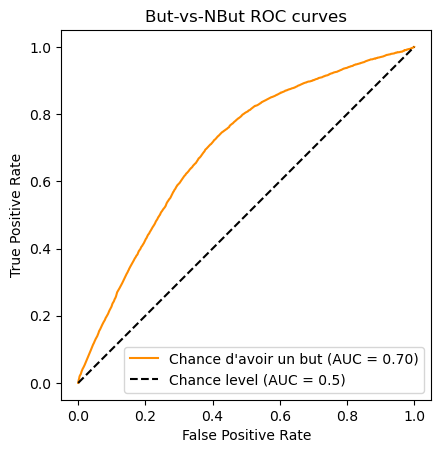

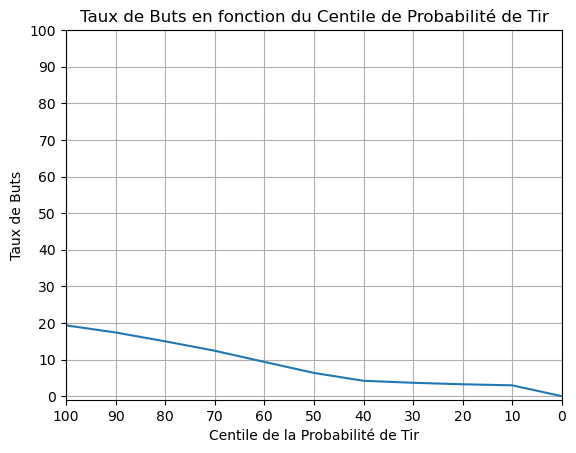

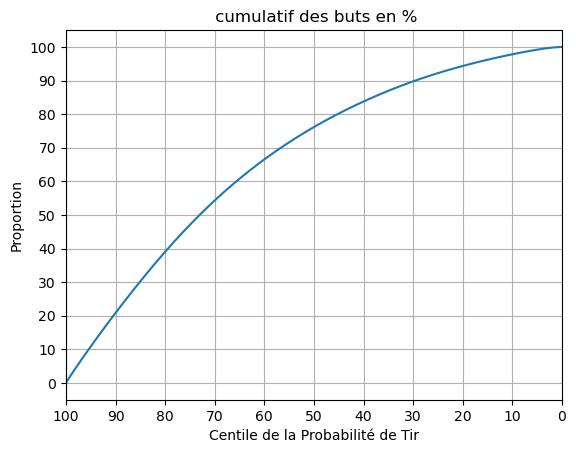

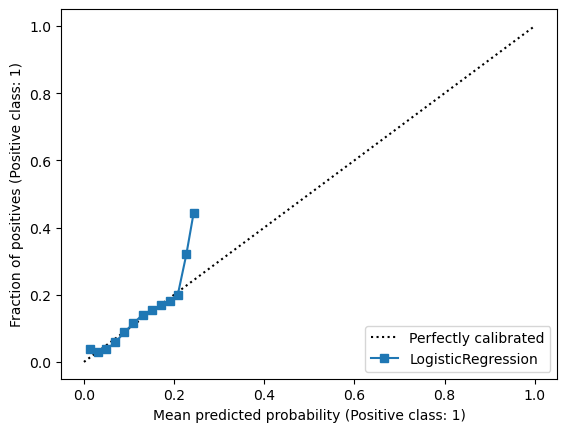

In [18]:
# on s'intéresse à la deuxième colonne y_score[:,1] qui représente la probabilité de prédire un but

# Receiver Operating Characteristic
ROC_plot(y_val, y_score[:,1])

# Taux de buts
Centiles_plot(y_val, y_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y_val, y_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf,reshaped_X_val, reshaped_y_val, n_bins=50)

### Régression logisrique entrainnée sur la caractéristique 'Angle' uniquement

In [19]:
X_1 = data['angle_goal']
X1_train, X1_val, y1_train, y1_val = train_test_split(
        X_1, y, test_size=0.2, random_state=42
        )

X1_train = X1_train.values.reshape(-1,1)
y1_train = y1_train.values.reshape(-1,1)
reshaped_X1_val = X1_val.values.reshape(-1,1)
reshaped_y1_val = y1_val.values.reshape(-1,1)

clf_1 = LogisticRegression().fit(X1_train, y1_train)

y1_score = clf_1.predict_proba(reshaped_X1_val)

C:\Users\mathi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC metric : 0.5020579700966246


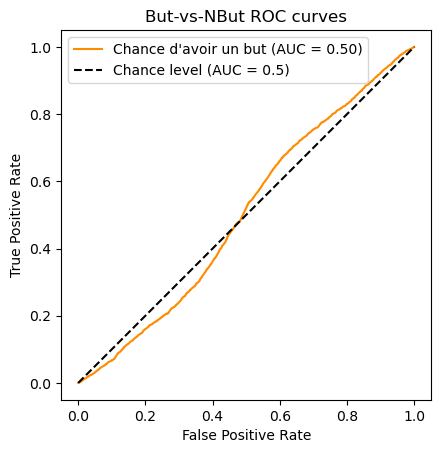

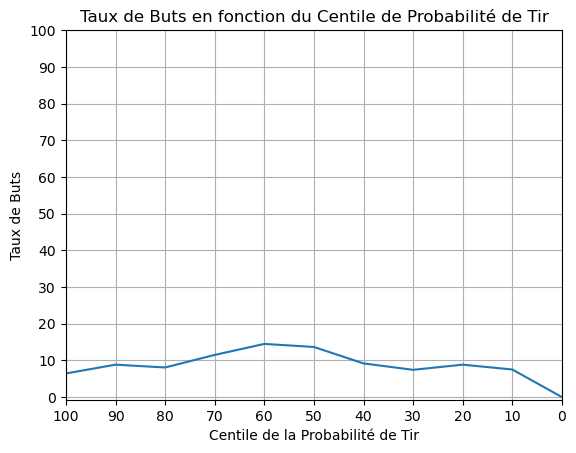

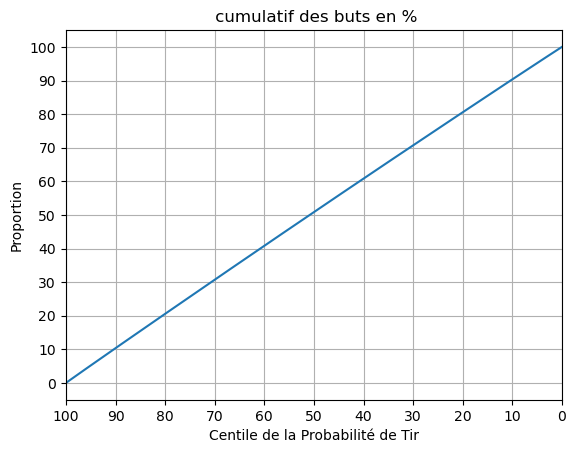

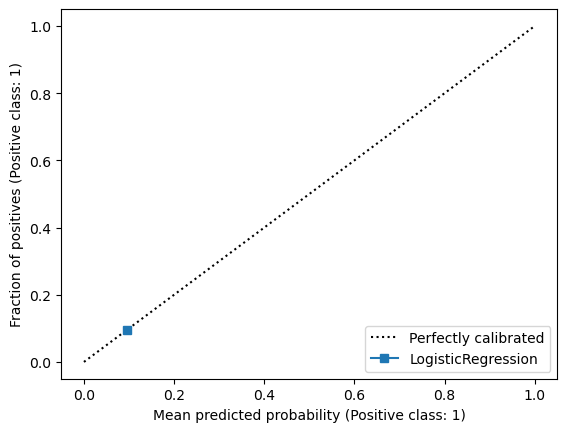

In [20]:
# Receiver Operating Characteristic
ROC_plot (y1_val, y1_score[:,1])

# Taux de buts
Centiles_plot(y1_val, y1_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y1_val, y1_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf_1,reshaped_X1_val, reshaped_y1_val, n_bins=50)

### Régression logistique entrainée sur les caractéristique 'distance' et 'Angle'

In [21]:
X_2 = data[['distance_goal','angle_goal']]
X2_train, X2_val, y2_train, y2_val = train_test_split(
        X_2, y, test_size=0.2, random_state=42
        )
y2_train = y2_train.values.reshape(-1,1)
reshaped_y2_val = y2_val.values.reshape(-1,1)
clf_2 = LogisticRegression().fit(X2_train, y2_train)
y2_score = clf_2.predict_proba(X2_val)

C:\Users\mathi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC metric : 0.6964502052410217


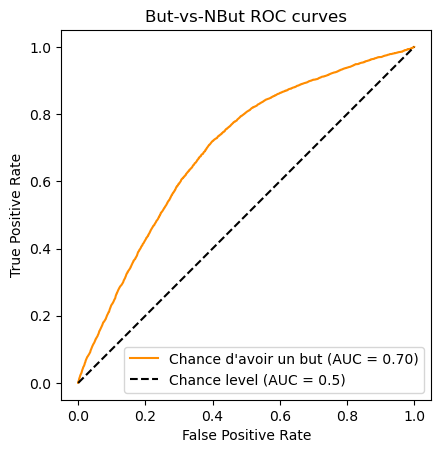

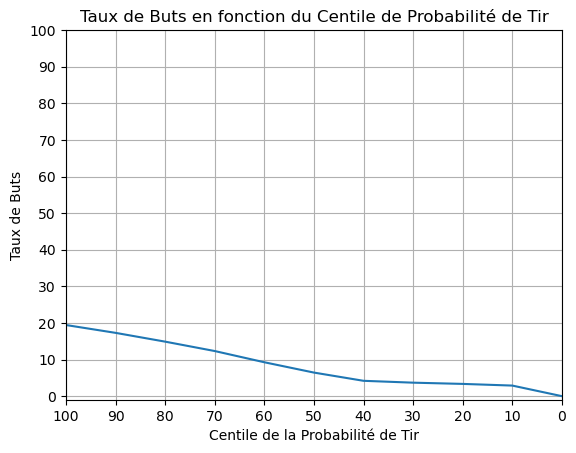

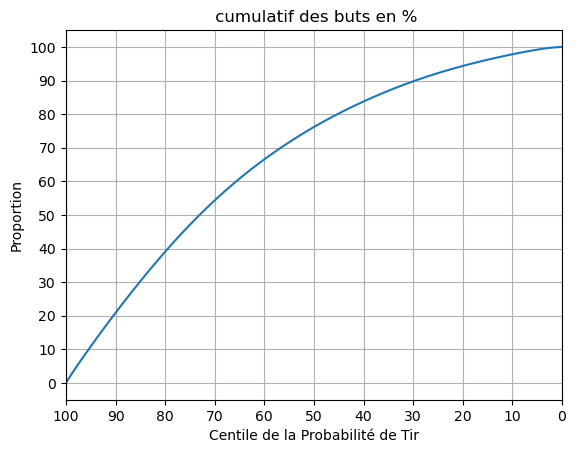

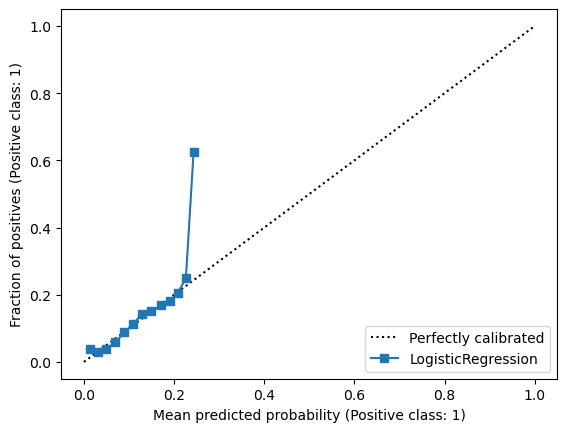

In [22]:
# Receiver Operating Characteristic
ROC_plot (y2_val, y2_score[:,1])

#Taux de buts
Centiles_plot(y2_val, y2_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y2_val, y2_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf_2,X2_val, reshaped_y2_val, n_bins=50)

### Régression logistique avec échantillonage uniforme

AUC metric : 0.4953581525399408


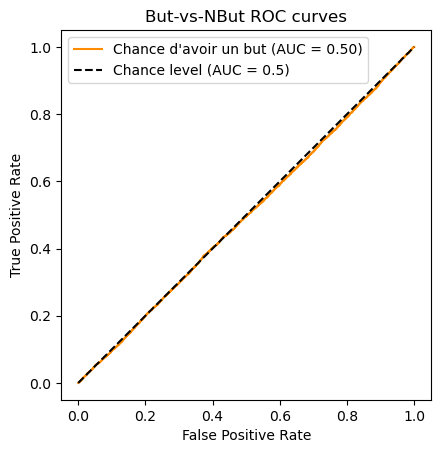

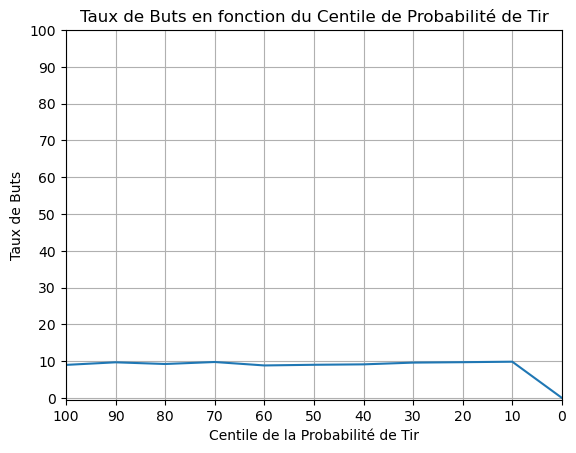

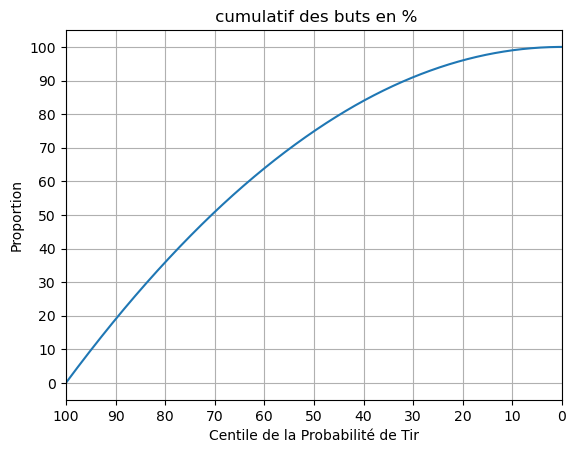

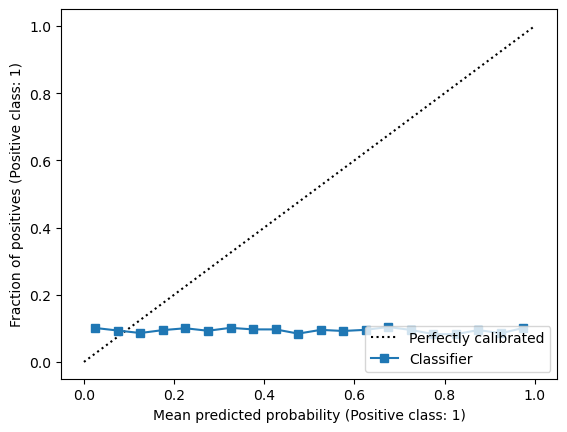

In [23]:
# Échantillonnage des probabilités prédites à partir d'une distribution uniforme U(0, 1)

y_uniform_sampled = np.random.uniform(0, 1, len(y2_score[:,1]))

# Receiver Operating Characteristic
ROC_plot (y2_val, y_uniform_sampled)

#Taux de buts
Centiles_plot(y2_val, y_uniform_sampled)

# Cumule de buts
cumulative_centiles_plot(y2_val, y_uniform_sampled)

# Courbe de calibration
CalibrationDisplay.from_predictions(y2_val, y_uniform_sampled, n_bins=20)

# Ingénierie des caractéristiques II

In [31]:
from comet_ml import Experiment
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scripts.Basic_model import *

In [34]:
data = pd.read_csv('../data/derivatives/train_data.csv')

In [35]:
experiment = Experiment(
    api_key="Bgx9192SVK3nzJNLQcV5nneQS",
    project_name="milestone-2",
    workspace="me-pic"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/me-pic/milestone-2/0bc0937f0804433e8cce7005c119361a
COMET INFO:   Parameters:
COMET INFO:     objective : binary:logistic
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (1013.59 KB)
COMET INFO:     installed p

### Setting label

In [36]:
X = data[['distance_from_last_event', 'changement_angle_tir']]
y = data['goalFlag']

### Splitting Data train / Val (80-20)

In [37]:
# On split 80 / 20 les donnees
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Training xgboost

In [38]:
xgboost_classifier = xgb.XGBClassifier()
xgboost_classifier.fit(X_train, y_train)

y_pred_proba = xgboost_classifier.predict_proba(X_test)[:, 1]

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

### Calculating ROC

ROC AUC Score: 0.5735962878368401


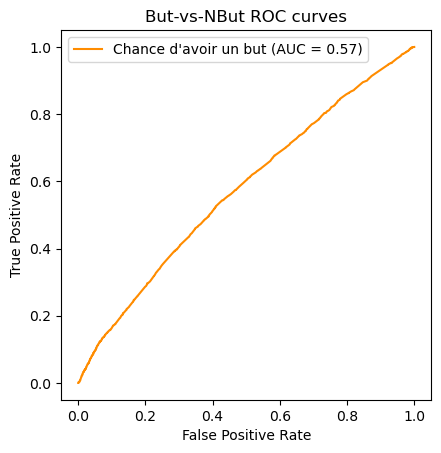

AUC metric : 0.5735962878368401


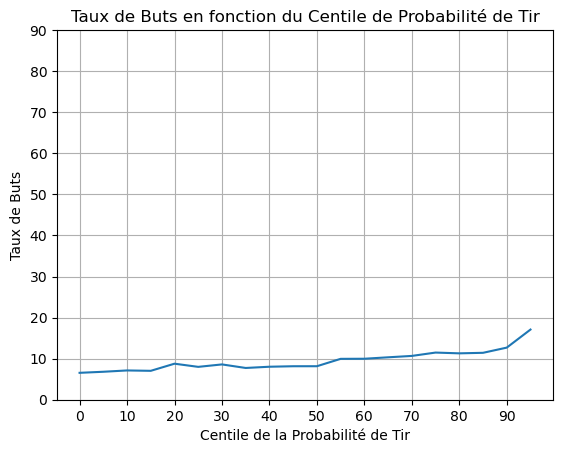

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


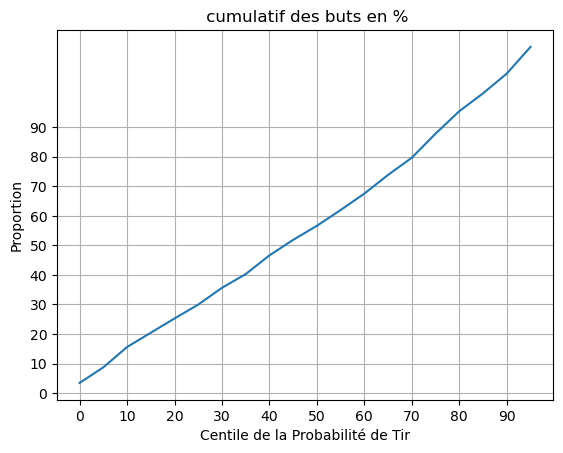

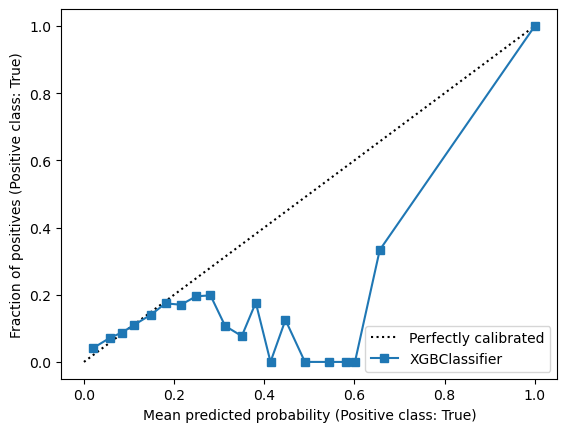

In [40]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC_plot(y_test, y_pred_proba)

#Taux de buts
Centiles_plot(y_test, y_pred_proba)

# Cumule de buts
cumulative_centiles_plot(y_test, y_pred_proba)

# Calibration display
reshaped_X1_val = X_test.values.reshape(-1,1)
reshaped_y1_val = y_train.values.reshape(-1,1)
calibrate_display(xgboost_classifier, X_test, y_test, 30)

### Hyperparameter tuning

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune and their possible values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create the GridSearchCV object with cross-validation (e.g., 5-fold cross-validation)
grid_search = GridSearchCV(
    estimator=xgboost_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5
)

print("Training with the Grid Search")
# We train with the Grid Search
grid_search.fit(X_train, y_train)

# We output the best parameters that were given
print("Output the best hyperparams")
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Training with the Grid Search


C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

Output the best hyperparams
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


ROC AUC Score: 0.5838184167253935


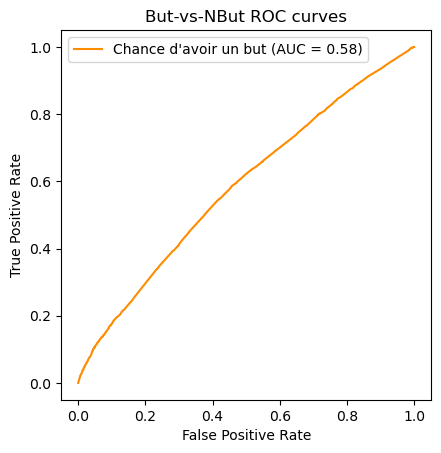

AUC metric : 0.5838184167253935


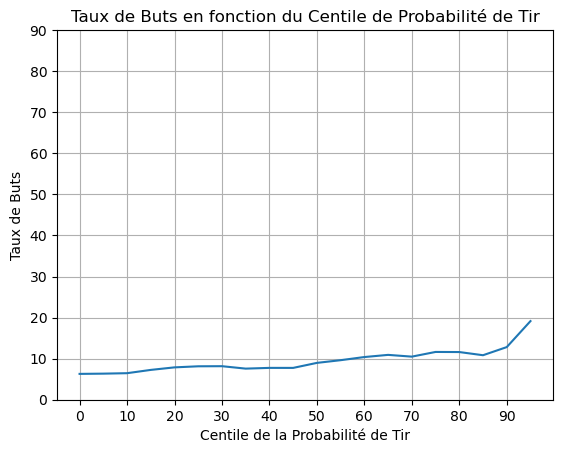

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
COMET E

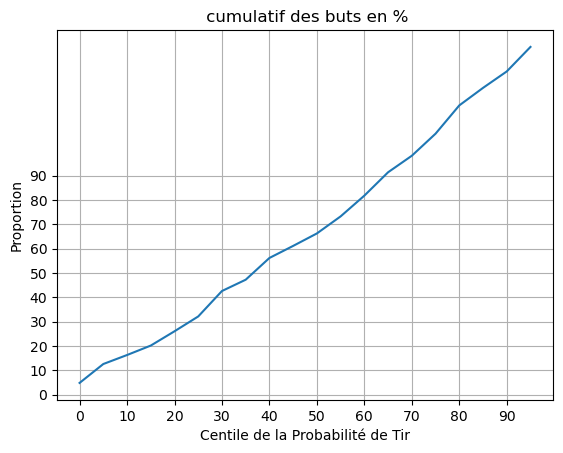

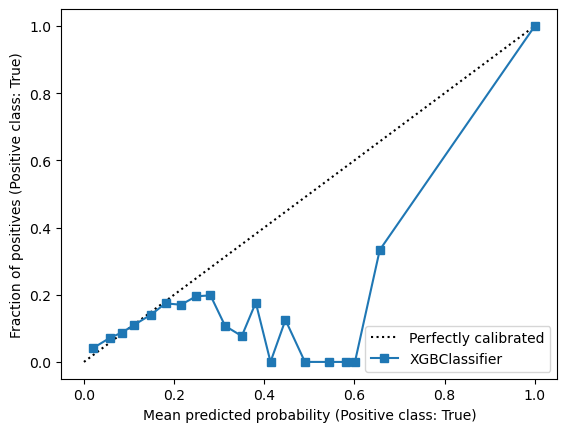

In [42]:
# We retrain the model with the new parameters
best_xgboost_classifier = grid_search.best_estimator_
y_pred_proba = best_xgboost_classifier.predict_proba(X_test)[:, 1]

# We evaluate once again
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC_plot(y_test, y_pred_proba)

#Taux de buts
Centiles_plot(y_test, y_pred_proba)

# Cumule de buts
cumulative_centiles_plot(y_test, y_pred_proba)

# Calibration display
calibrate_display(xgboost_classifier, X_test, y_test, 30)

experiment.log_parameter("learning_rate", best_xgboost_classifier.learning_rate)
experiment.log_parameter("max_depth", best_xgboost_classifier.max_depth)
experiment.log_parameter("n_estimator", best_xgboost_classifier.n_estimators)

experiment.log_metric("SOC", roc_auc)

experiment.log_model("best_xgboost_classifier", best_xgboost_classifier)

### Feature Selection

In [43]:
# XGBoost has a L1 regularization term that we can use to identify features that are assigned the 0 weight

xgboost_classifier = xgb.XGBClassifier(learning_rate=best_xgboost_classifier.learning_rate, n_estimators=best_xgboost_classifier.n_estimators, max_depth=best_xgboost_classifier.max_depth, reg_alpha=1)  # Add reg_alpha for L1 regularization
xgboost_classifier.fit(X_train, y_train)

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Test After Feature selection

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


ROC AUC Score: 0.5836028893587033


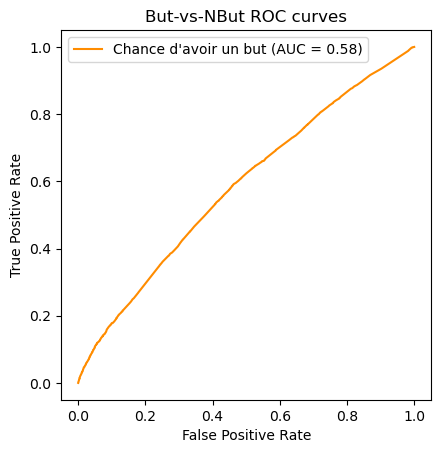

AUC metric : 0.5836028893587033


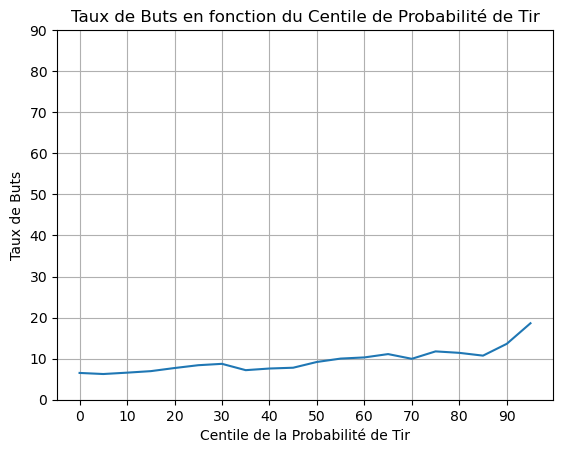

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


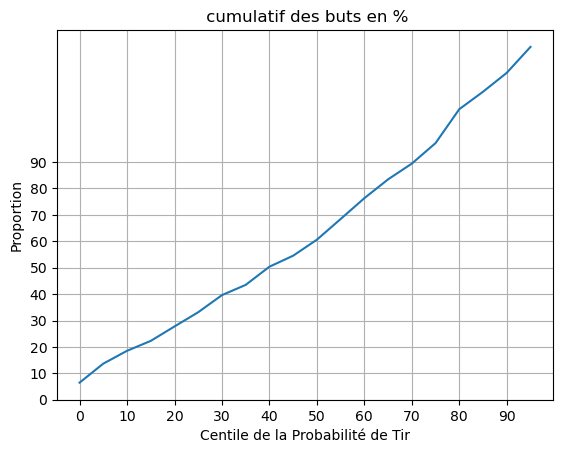

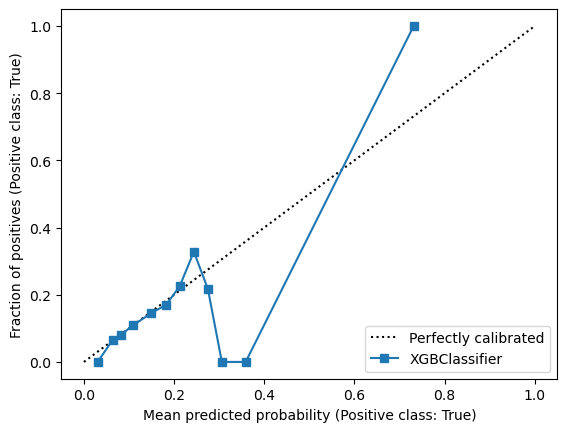

In [44]:
y_pred_proba = xgboost_classifier.predict_proba(X_test)[:, 1]

# We evaluate once again
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC_plot(y_test, y_pred_proba)

#Taux de buts
Centiles_plot(y_test, y_pred_proba)

# Cumule de buts
cumulative_centiles_plot(y_test, y_pred_proba)

# Calibration display
calibrate_display(xgboost_classifier, X_test, y_test, 30)

experiment.log_parameter("learning_rate", best_xgboost_classifier.learning_rate)
experiment.log_parameter("max_depth", best_xgboost_classifier.max_depth)
experiment.log_parameter("n_estimator", best_xgboost_classifier.n_estimators)

experiment.log_metric("SOC", roc_auc)

# Faites de votre mieux!